# Estimate residence time based on dPb and removal rates

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
from matplotlib.colors import ListedColormap
import forcing.modules.mapping_functions as mf

%matplotlib inline

#### Parameters:

In [3]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,777,797) # Northern Canada Basin
bdy_WCB = (2167,2177,390,797) # Western Canada Basin
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,291,301) # Hudson Bay
land_color  = '#a9a7a2'

#### Load files:

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = np.array(mfile.variables['nav_lon'])
mesh_lat = np.array(mfile.variables['nav_lat'])
mask     = np.array(mfile.variables['tmask'][0])
mesh_bathy   = np.array(mfile.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mfile.variables['nav_lev'])

In [46]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mf    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = np.array(mf.variables['hdept'])[0,:,:]
# mesh_lon = np.array(mfile.variables['nav_lon'])
# mesh_lat = np.array(mfile.variables['nav_lat'])
# mask     = np.array(mfile.variables['tmask'][0])
# mesh_bathy   = np.array(mfile.variables['tmask'][0,:,:,:])
# bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
# mesh_depth   = np.array(mfile.variables['nav_lev'])

In [5]:
# Observed Pb residence times:
# Pb residence time estimates from the literature: (Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp)

# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon, mesh_lat) 
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, mesh_lon, mesh_lat) 

# Bacon et al., 1976: Atlantic Ocean
Bacon_depth   = [300, 4880, 5003, 3820, 4940, 4950, 4440] # marked by top and bottom of range
Bacon_restime = [2.3, 20, 21, 54, 93, 90, 60]

# Henderson and Maier-Reimer, 2002: North Atlantic
HMR_depth   = [75, 2000]
HMR_restime = [3, 30] 

# Moore and Smith, 1986: 
MS_depth   = [200, 1770]
MS_restime = [5, 21] 

# Ones with only surface, intermediate or deep defined:
sid_depth = [5, 1500, 3000]
craig_restime   = [2, np.nan, 54]   # Craig et al., 1973; Pacific Ocean
nozaki_restime  = [1.7, 15, 100]    # Nozaki et al., 1976, 1990; Pacific Ocean
schaul_restime  = [1.6, np.nan, 50] # Schaule and Patterson, 1983; Sargasso Sea
schaul1_restime = [np.nan, 20, 80]  # Schaule and Patterson, 1981; North Pacific
shen_restime    = [2.5, np.nan, np.nan] # Shen and Boyle, 1988; Bermuda

#### Functions

In [6]:
def load_monthly_comp(folder, year, month):
    # Load file of monthly average:    
    comp = xr.open_dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')

    dpb      = comp['dissolpb'].values[0,:,:,:] # dissolved Pb concentration
    dpb_ads  = comp['dpbads'].values[0,:,:,:]   # scavenging removal
    
    return dpb, dpb_ads

In [7]:
def calc_residence_time(folder, year, month):
    
    dPb, dPb_ads = load_monthly_comp(folder, year, month)
    
    # Inventory of [dPb]:
    inventory = dPb 
    
    # Removal rate of [dPb]:
    removal   = dPb_ads
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time, dPb, dPb_ads

In [8]:
def calc_annual_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = dPb_total
    
    # Removal rate of [dPb]:
    removal   = scav_total
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [9]:
def calc_basin_annual_residence_time(folder, year):
    # Calculate typical residence time profiles in different regions:
    # - Canada Basin
    # - CAA
    # - Baffin Bay
    # - Labrador Sea
    ## Approach: create masks for regions, then apply calculation over these masks. multiply each grid point by cell area
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = dPb_total
    
    # Removal rate of [dPb]:
    removal   = scav_total
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [10]:
def plot_layer(variable, layer, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    CB = proj1.pcolormesh(x, y, variable[layer,:,:], cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)  
    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=ListedColormap([land_color]), vmin=0, vmax=1)
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if layer < 17:
        x_kadko, y_kadko = proj1(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj1(chen_lons, chen_lats)
        CB = proj1.scatter(x_kadko, y_kadko, c=kadko_res, s=20, edgecolor='w', linewidth=0.5, \
                          zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
        proj1.scatter(x_chen, y_chen, c=chen_res, s=20, edgecolor='w', linewidth=0.5, \
                     zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
    
    ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Residence time [years]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

#### Calculations

Pb residence time:
$$\tau_{scav} = \frac{inventory\ of\ [dPb]}{removal\ rate\ of\ [dPb]}$$

Should look at over the span of a year to get a better idea

In [10]:
residence_time_200201, dPb_200201, scav_200201 = calc_residence_time('/data/brogalla/run_storage/Pb-new-ini2-spin1/', 2002, 1)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [122]:
residence_time_2002 = calc_annual_residence_time('/data/brogalla/run_storage/Pb-new-ini2/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [95]:
residence_time_2002 = calc_annual_residence_time('/data/brogalla/run_storage/Pb-new-ini2-spin1/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Calculate the difference between the model residence time and the observed residence time in the upper 56 m:

In [10]:
kadko_res_time_diff     = np.empty((len(kadko_res),len(constants),len(betas))); kadko_res_time_diff[:]     = np.nan;
kadko_modelled_res_time = np.empty((len(kadko_res),len(constants),len(betas))); kadko_modelled_res_time[:] = np.nan;
chen_res_time_diff      = np.empty((len(chen_res),len(constants),len(betas)));  chen_res_time_diff[:]      = np.nan;
chen_modelled_res_time  = np.empty((len(chen_res),len(constants),len(betas)));  chen_modelled_res_time[:]  = np.nan;
        
# Difference be tween modeled and observed residence time at the stations:
# Kadko et al., 2019
for n, stn in enumerate(zip(kadko_ANHA12_i, kadko_ANHA12_j)):
    if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
        stni = int(stn[0]); stnj = int(stn[1]);
        kadko_modelled_res_time[n,ci,bi] = np.mean(res_time_yrs[0:18,stni,stnj],axis=0)                # mean over upper 50 m
        kadko_res_time_diff[n,ci,bi]     = kadko_res[n] - np.mean(res_time_yrs[0:18,stni,stnj],axis=0) # mean over upper 50 m
# Chen et al., 2012

for n, stn in enumerate(zip(chen_ANHA12_i, chen_ANHA12_j)):
    if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
        stni = int(stn[0]); stnj = int(stn[1]);
        chen_modelled_res_time[n,ci,bi] = np.mean(res_time_yrs[0:18,stni,stnj],axis=0)               # mean over upper 50 m
        chen_res_time_diff[n,ci,bi]     = chen_res[n] - np.mean(res_time_yrs[0:18,stni,stnj],axis=0) # mean over upper 50 m
                
# Calculate mean difference and RMS between model residence time and observed residence time:
kadko_res_time_diff_mean = np.nanmean(kadko_res_time_diff, axis=0)
chen_res_time_diff_mean  = np.nanmean(chen_res_time_diff, axis=0)
kadko_res_time_rms       = np.sqrt(np.nansum(kadko_res_time_diff**2, axis=0)/np.count_nonzero(~np.isnan(kadko_res_time_diff)))
chen_res_time_rms        = np.sqrt(np.nansum(chen_res_time_diff**2, axis=0)/np.count_nonzero(~np.isnan(chen_res_time_diff)))

NameError: name 'constants' is not defined

#### Figures

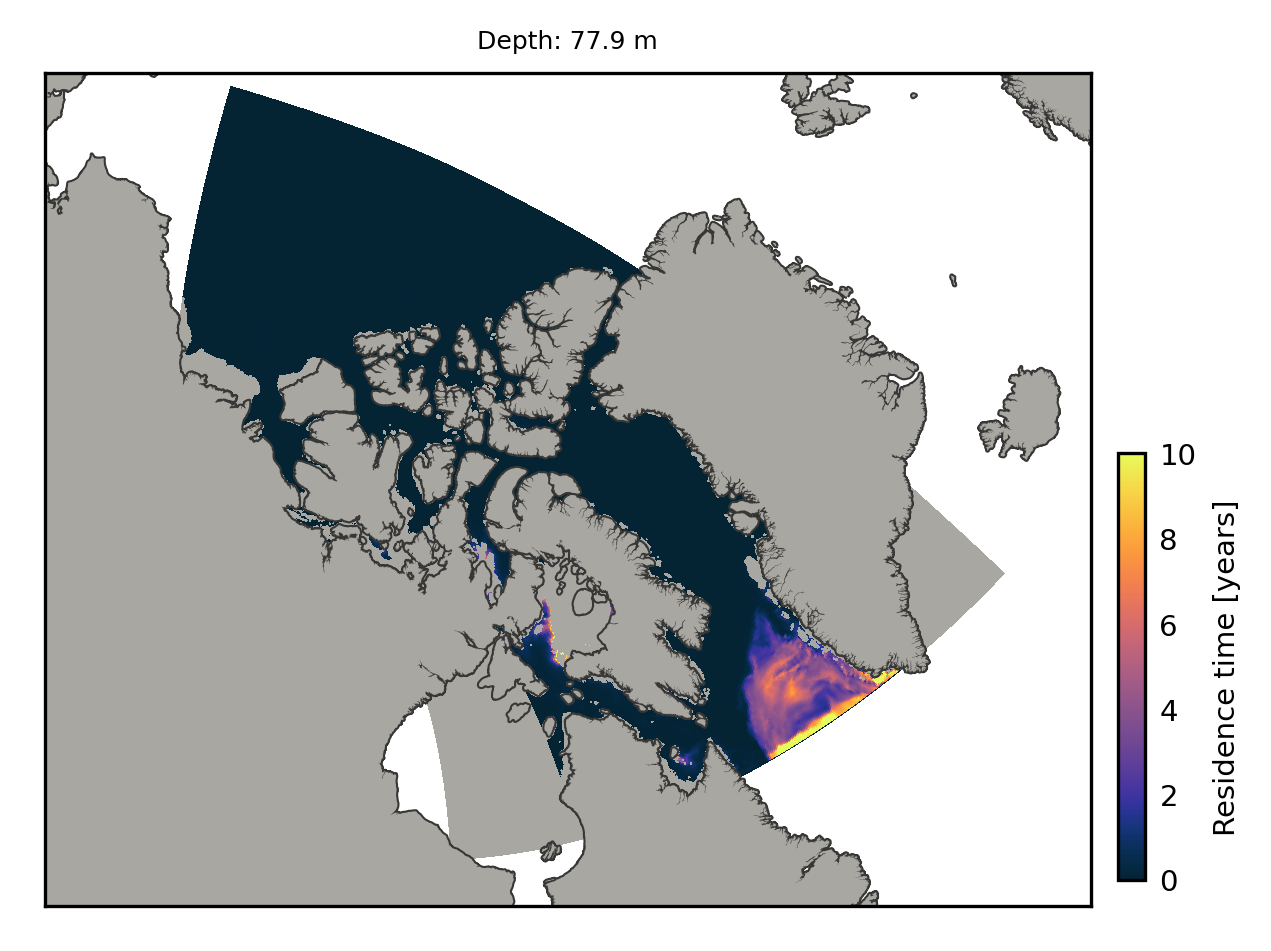

In [27]:
plot_layer(scav_200201*1e18, 20, vmin=0, vmax=10)

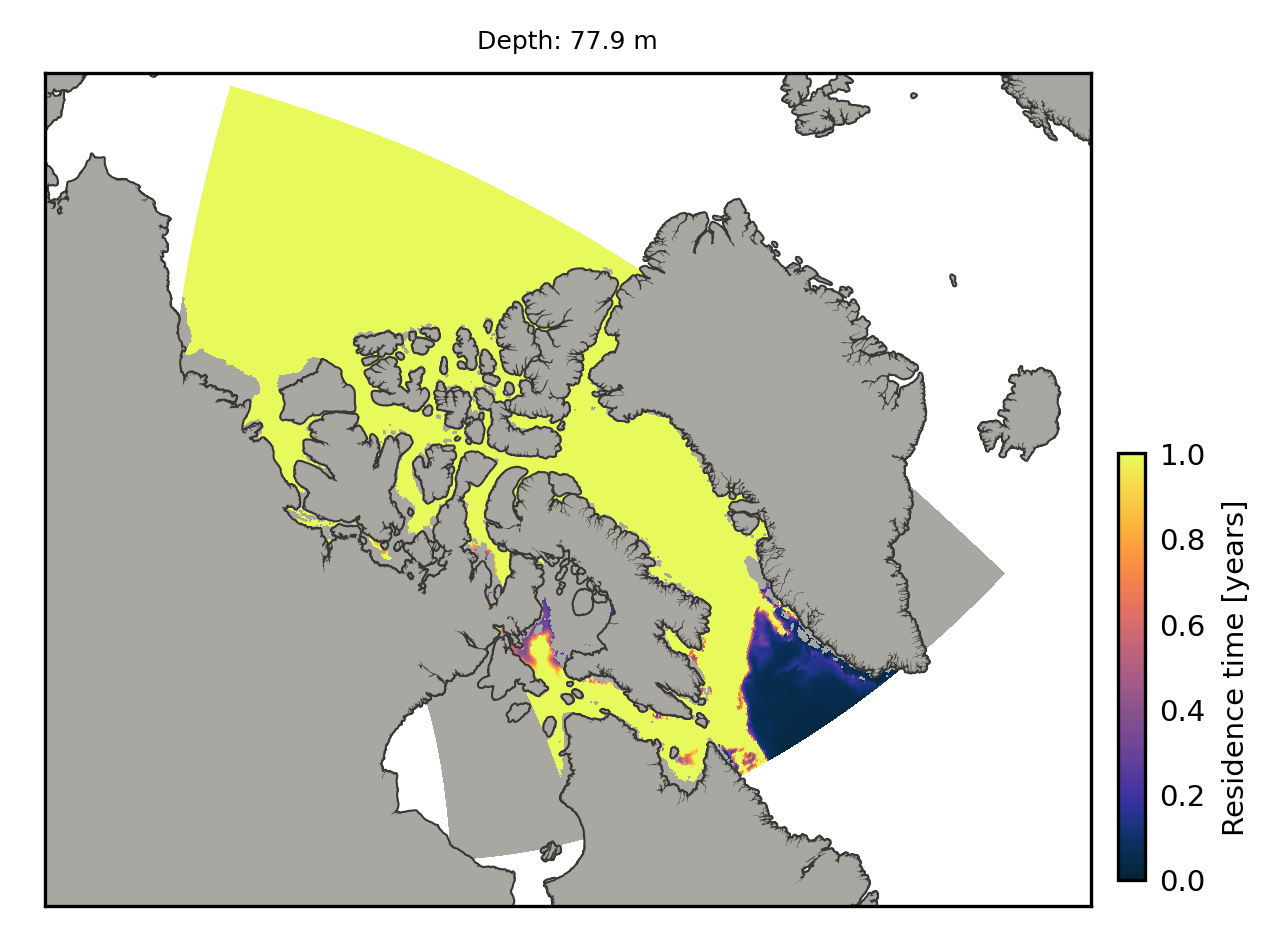

In [21]:
plot_layer(residence_time_200201, 20, vmin=0, vmax=1)

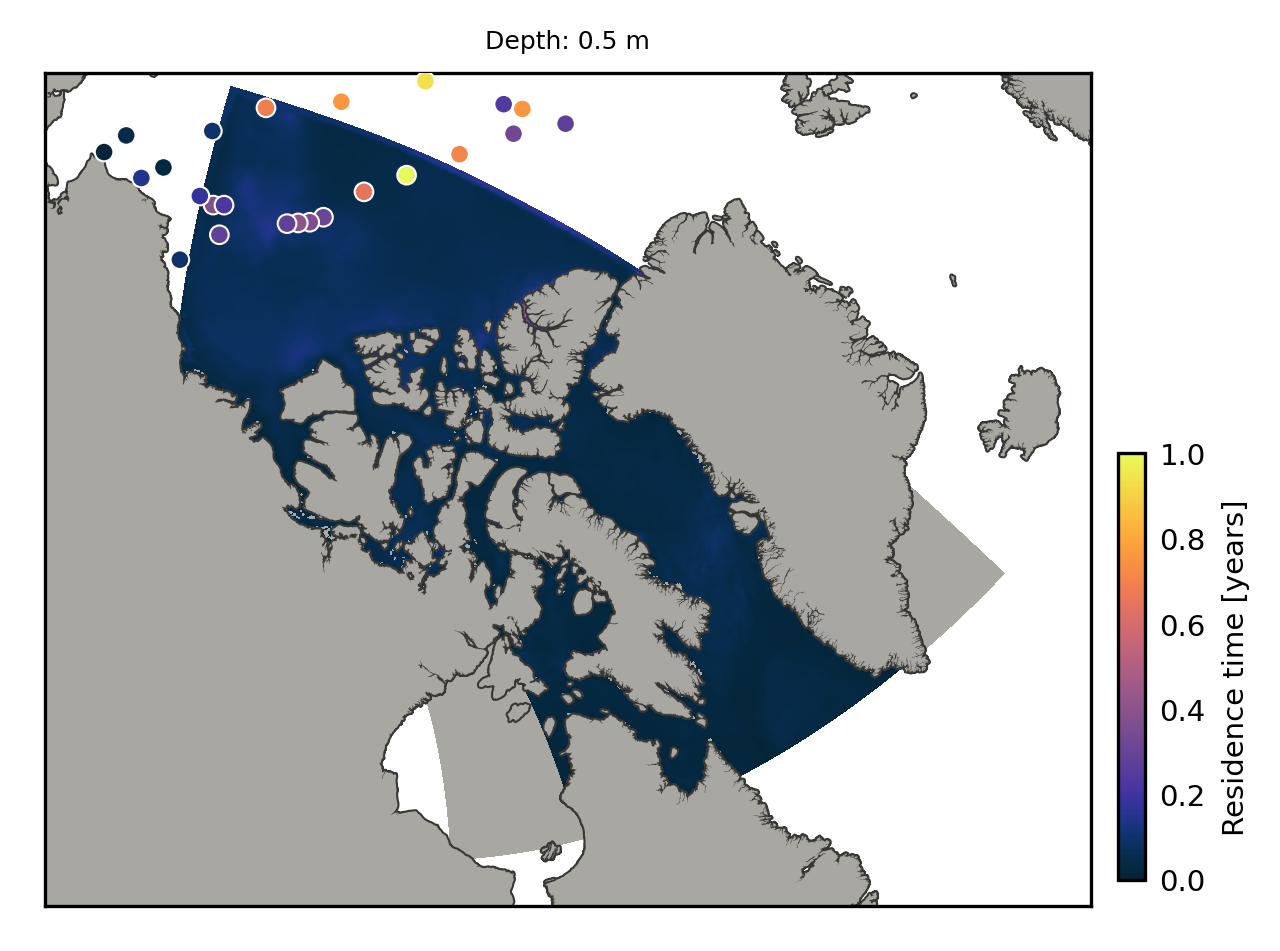

In [35]:
plot_layer(residence_time_2002, 0, vmin=0, vmax=1)

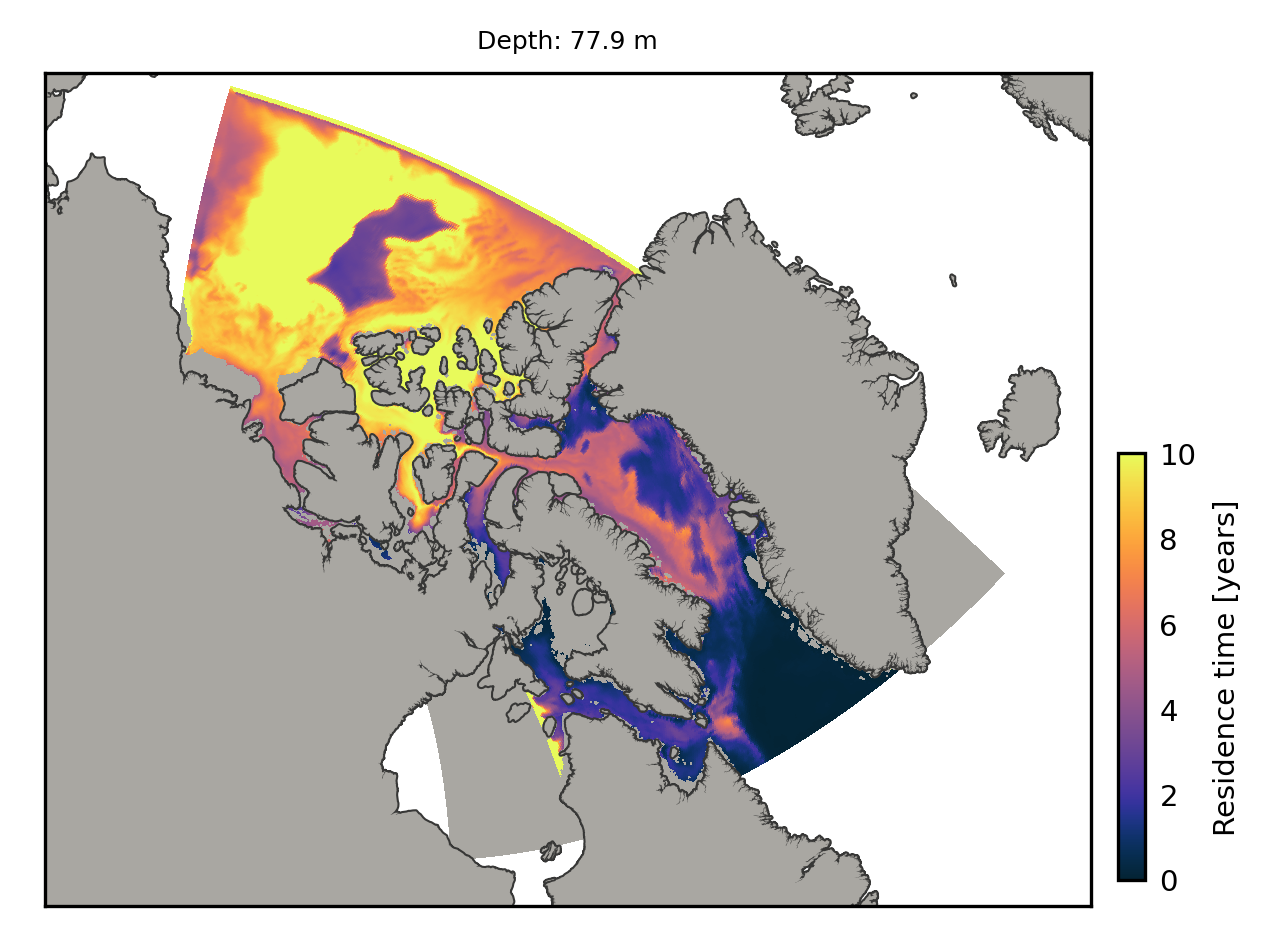

In [14]:
plot_layer(residence_time_2002, 20, vmin=0, vmax=10)

#### Spatial variation in residence time

Calculate as scatter plot, with correlation.

In [13]:
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

(50, 1040, 640)

In [44]:
# Since the observed Pb residence times in the Arctic Ocean are estimated based on the upper 60 m,
# we need to calculate the cumulative inventory of Pb in the model in the upper 56 m and the cumulative removal

# Observations:
kadko_i, kadko_j  = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
restime_obs       = kadko_res[~np.isnan(kadko_i)]
restime_obs_depth = kadko_depths[~np.isnan(kadko_i)]

# Model:
restime_model = np.copy(residence_time_2002)
obs_i         = kadko_i[~np.isnan(kadko_i)]
obs_j         = kadko_j[~np.isnan(kadko_j)]
restime_model_match = [restime_model[:,int(obs_i[n]),int(obs_j[n])] for n in range(0,len(obs_i))]
# restime_model[0:19] # up to 56 m

In [46]:
restime_model_match[0,:,:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
corr_mtx = np.corrcoef(restime_obs, restime_model)

In [ ]:
# Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if layer < 17:
        x_kadko, y_kadko = proj1(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj1(chen_lons, chen_lats)
        CB = proj1.scatter(x_kadko, y_kadko, c=kadko_res, s=20, edgecolor='w', linewidth=0.5, \
                          zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
        proj1.scatter(x_chen, y_chen, c=chen_res, s=20, edgecolor='w', linewidth=0.5, \
                     zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)

#### Vertical variation in residence time

In [126]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
#     CAA_mask[depth][hdept < 50]      = 0
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

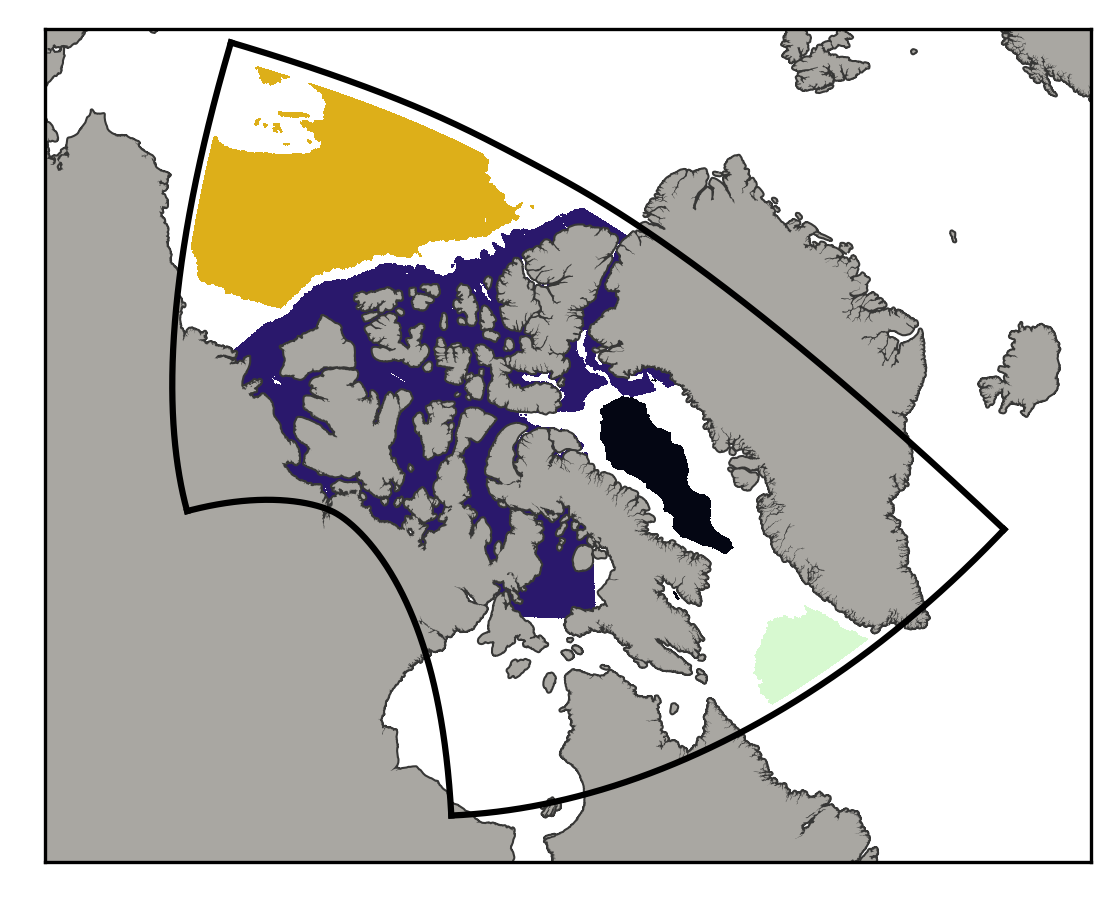

In [127]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

proj1.plot(x[:,0] ,y[:,0] ,'-k')
proj1.plot(x[:,-1],y[:,-1],'-k')
proj1.plot(x[0,:] ,y[0,:] ,'-k')
proj1.plot(x[-1,:],y[-1,:],'-k')

CB_mask_plot  = np.ma.masked_where(CB_mask < 1 , CB_mask)
CAA_mask_plot = np.ma.masked_where(CAA_mask < 1, CAA_mask)
BB_mask_plot  = np.ma.masked_where(BB_mask < 1 , BB_mask)
LS_mask_plot  = np.ma.masked_where(LS_mask < 1 , LS_mask)
proj1.pcolormesh(x, y, CB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.oxy_r) 
proj1.pcolormesh(x, y, CAA_mask_plot[layer,imin:imax,jmin:jmax], cmap=cmocean.cm.haline)
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.ice) 
proj1.pcolormesh(x, y, LS_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.algae) 

In [128]:
# Separate based on region:
CB_residence_time  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time_2002)
CAA_residence_time = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, residence_time_2002)
BB_residence_time  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time_2002)
LS_residence_time  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , residence_time_2002)

# Calculate mean over each of the regions:
CB_mean_restime    = np.ma.mean(CB_residence_time , axis=(1,2))
CAA_mean_restime   = np.ma.mean(CAA_residence_time, axis=(1,2))
BB_mean_restime    = np.ma.mean(BB_residence_time , axis=(1,2))
LS_mean_restime    = np.ma.mean(LS_residence_time , axis=(1,2))

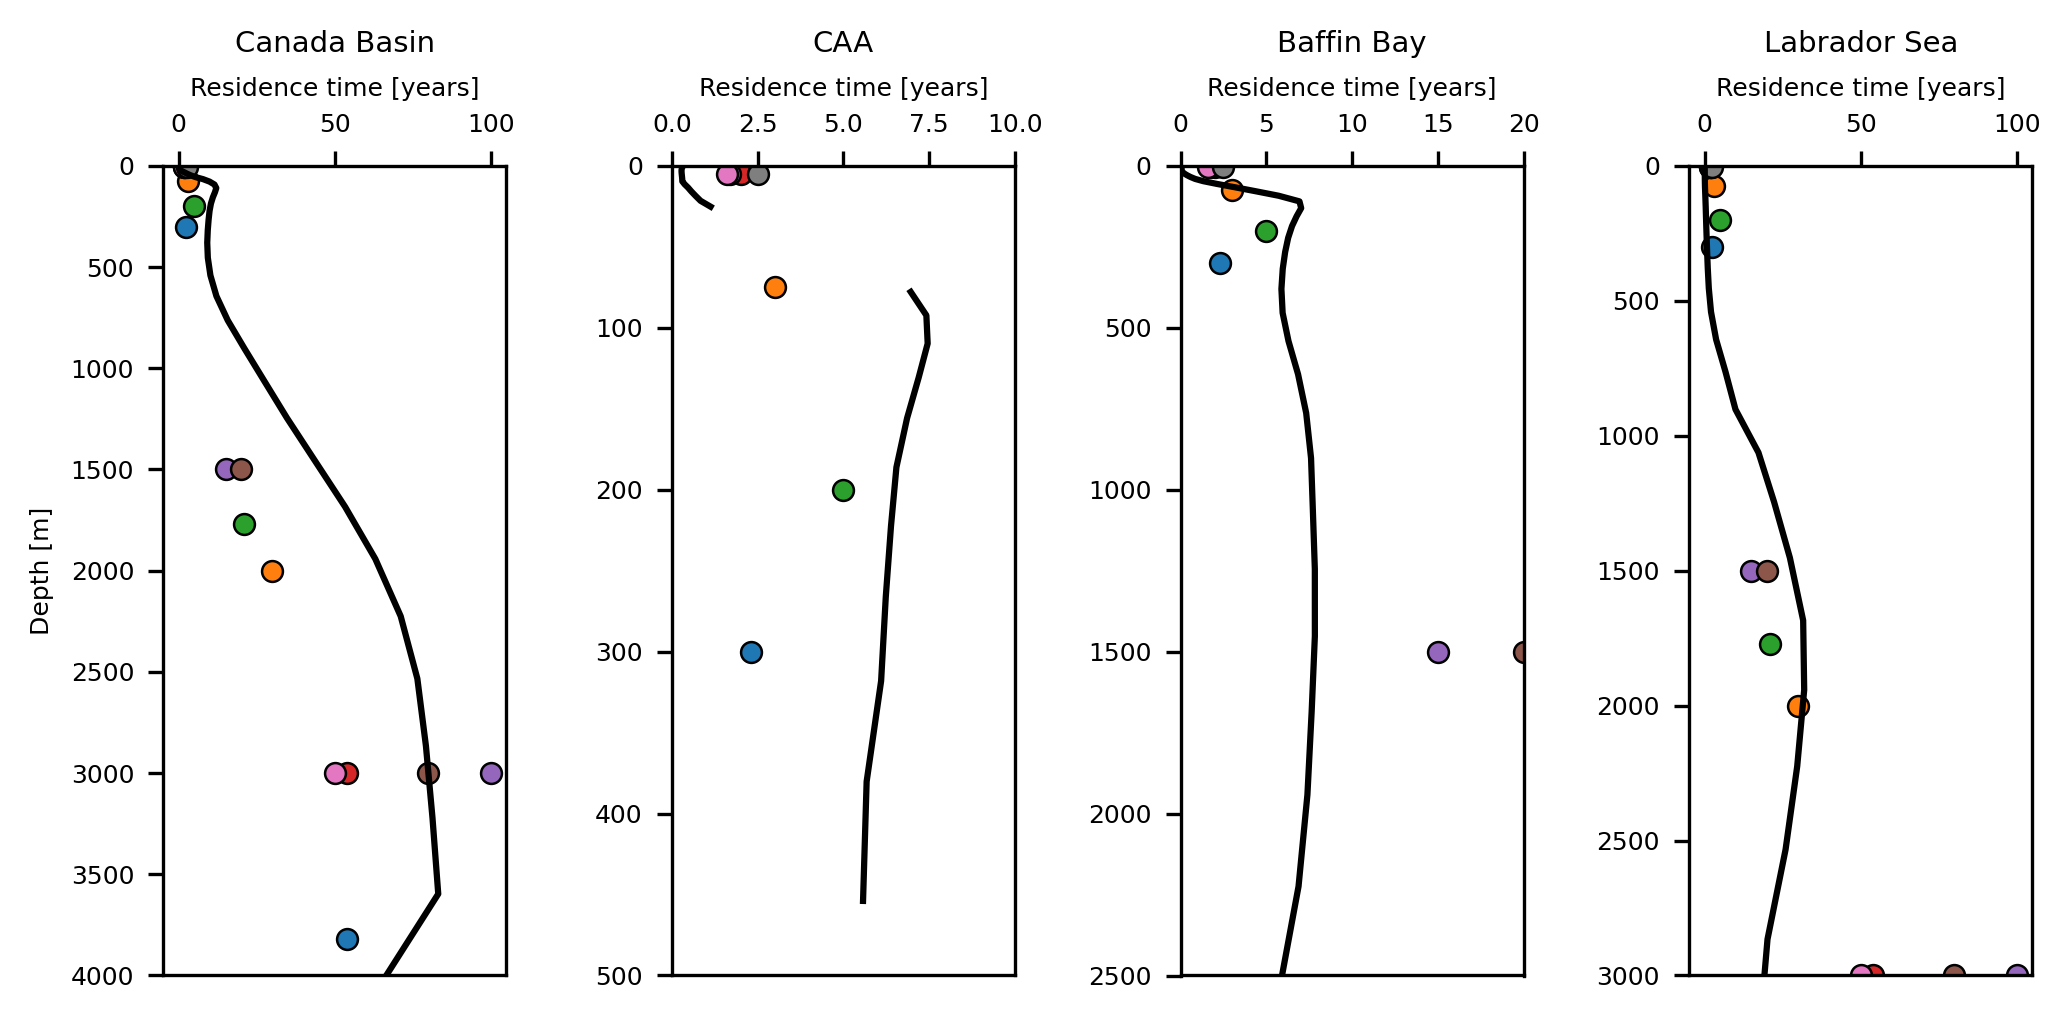

In [121]:
fig, ax = plt.subplots(1, 4, figsize=(7,3.5), dpi=300)
for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)
    axis.invert_yaxis()
    axis.set_xlabel('Residence time [years]', fontsize=6)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
#     axis.set_xlim(0,15)
    
    # Observations:
    axis.plot(Bacon_restime, Bacon_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Bacon et al., 1976; Atlantic', markersize=10)
    axis.plot(HMR_restime, HMR_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Henderson & Maier-Reimer, 2002; Atlantic', markersize=10)
    axis.plot(MS_restime, MS_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Moore and Smith, 1986; Arctic', markersize=10)
    axis.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Craig et al., 1973; Pacific', markersize=10)
    axis.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Nozaki et al, 1976; Pacific', markersize=10)
    axis.plot(schaul1_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Schaul and Patterson, 1981; N. Pacific', markersize=10)
    axis.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Schaul and Patterson, 1983; Sargasso', markersize=10)
    axis.plot(shen_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Shen and Boyle, 1988; Bermuda', markersize=10)

ax[0].set_ylabel('Depth [m]', fontsize=6)
ax[0].set_title('Canada Basin', fontsize=7)
ax[1].set_title('CAA', fontsize=7)
ax[2].set_title('Baffin Bay', fontsize=7)
ax[3].set_title('Labrador Sea', fontsize=7)

ax[0].plot(CB_mean_restime,  mesh_depth, '-k') # CB
ax[1].plot(CAA_mean_restime, mesh_depth, '-k') # CAA
ax[2].plot(BB_mean_restime,  mesh_depth, '-k') # BB
ax[3].plot(LS_mean_restime,  mesh_depth, '-k') # LS

ax[0].set_ylim(4000,0)
ax[1].set_ylim(500,0);  ax[1].set_xlim(0,10);
ax[2].set_ylim(2500,0); ax[2].set_xlim(0,20);
ax[3].set_ylim(3000,0)

plt.tight_layout()

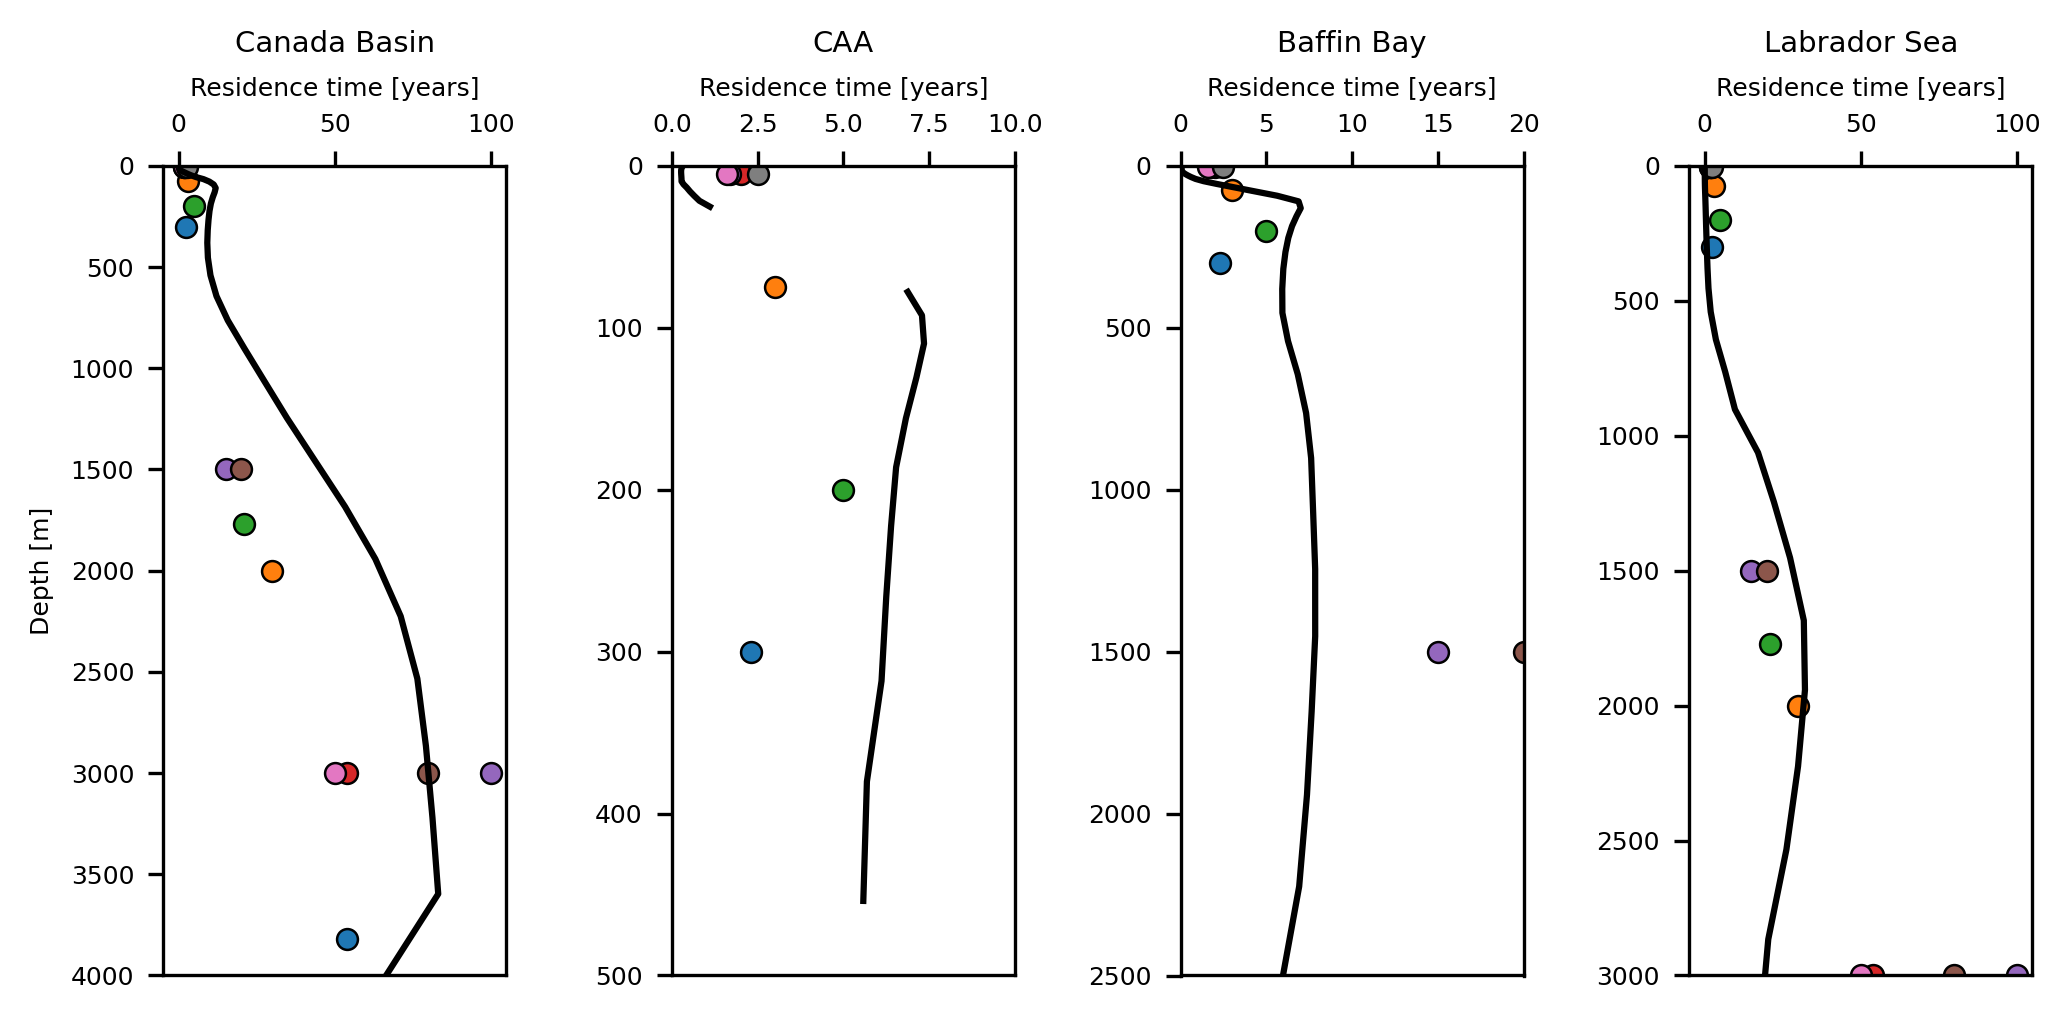

In [129]:
fig, ax = plt.subplots(1, 4, figsize=(7,3.5), dpi=300)
for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)
    axis.invert_yaxis()
    axis.set_xlabel('Residence time [years]', fontsize=6)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
#     axis.set_xlim(0,15)
    
    # Observations:
    axis.plot(Bacon_restime, Bacon_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Bacon et al., 1976; Atlantic', markersize=10)
    axis.plot(HMR_restime, HMR_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Henderson & Maier-Reimer, 2002; Atlantic', markersize=10)
    axis.plot(MS_restime, MS_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Moore and Smith, 1986; Arctic', markersize=10)
    axis.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Craig et al., 1973; Pacific', markersize=10)
    axis.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Nozaki et al, 1976; Pacific', markersize=10)
    axis.plot(schaul1_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Schaul and Patterson, 1981; N. Pacific', markersize=10)
    axis.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Schaul and Patterson, 1983; Sargasso', markersize=10)
    axis.plot(shen_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, \
             label='Shen and Boyle, 1988; Bermuda', markersize=10)

ax[0].set_ylabel('Depth [m]', fontsize=6)
ax[0].set_title('Canada Basin', fontsize=7)
ax[1].set_title('CAA', fontsize=7)
ax[2].set_title('Baffin Bay', fontsize=7)
ax[3].set_title('Labrador Sea', fontsize=7)

ax[0].plot(CB_mean_restime,  mesh_depth, '-k') # CB
ax[1].plot(CAA_mean_restime, mesh_depth, '-k') # CAA
ax[2].plot(BB_mean_restime,  mesh_depth, '-k') # BB
ax[3].plot(LS_mean_restime,  mesh_depth, '-k') # LS

ax[0].set_ylim(4000,0)
ax[1].set_ylim(500,0);  ax[1].set_xlim(0,10);
ax[2].set_ylim(2500,0); ax[2].set_xlim(0,20);
ax[3].set_ylim(3000,0)

plt.tight_layout()